# **Detecting Outliers Using `get_outliers`**
### *Wavelet-based outliers detection*

## **📌 Understanding the Outlier Detection Algorithm in Multifractal Analysis**

The function **`get_outliers()`** is a function from the pymultifracs library,  designed to identify and remove impulsive noise from time series before performing **Multifractal Analysis (MFA)**. Below is an overview of the **theory, steps, and implementation**.

Multifractal Analysis (MFA) relies on precise scaling properties of signals. However, **impulsive noise (outliers)** can distort these properties, leading to incorrect estimates of multifractal parameters. This is particularly problematic in **electrophysiological signals** (EEG, MEG) where artifacts like muscle movements, eye blinks, and external interferences introduce sudden fluctuations.

To address this, The get_outliers function proposed a **wavelet-based outlier detection method** that:
1. **Transforms the time series** into the wavelet domain (time-scale representation).
2. **Segments the wavelet coefficients** using the **PELT algorithm** (Pruned Exact Linear Time).
3. **Computes the Wasserstein distance** between segments to identify significant deviations.
4. **Removes outlier regions** from the multifractal estimation process.

The `get_outliers()` function operates in several key steps:

### **1️. Compute Wavelet Coefficients**
**Function Used:** `wavelet_analysis()`

- Converts the **raw time series** into **wavelet coefficients**, capturing features at different scales.
- These coefficients represent fluctuations at different temporal resolutions, forming a **time-scale map**.

### **2️. Extract Wavelet Leaders**
**Function Used:** `compute_leaders()`

- Applies **wavelet p-leaders**, an extension of the standard wavelet transform that enhances detection of multifractal properties.
- The leaders help identify singularities in the signal, crucial for detecting **impulsive noise.**

### **3️. Segment the Time-Series using PELT**
**Function Used:** `PELT()` (inside `get_outliers()`)

- The **PELT (Pruned Exact Linear Time)** algorithm **segments** the wavelet coefficients into different regions.
- It finds **change points** where the statistical properties of the signal shift abruptly (i.e., locations of noise artifacts).

### **4️. Compute Wasserstein Distance for Outlier Detection**
**Function Used:** `DetectionRemoval()`

- Each segment is **compared to the overall signal** using the **Wasserstein distance**, which measures the difference between probability distributions.
- If a segment's distribution is **too different**, it is flagged as an outlier.

### **5️. Remove Identified Outliers**
**Function Used:** `cluster_reject_leaders()`

- The flagged outlier segments are removed from further **multifractal analysis**.
- This ensures that the final scaling function estimation is **not biased by noise artifacts**.

The function **returns two key outputs**:
1. **`leaders`** → Wavelet leaders that will be used for multifractal analysis.
2. **`idx_reject`** → Indices of outlier coefficients that were flagged and removed.

These outputs ensure that the **final multifractal parameters (cumulants, singularity spectrum, etc.) are computed only from clean data.**

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymultifracs.robust import get_outliers
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.mf_analysis import mfa 
from pymultifracs.robust.benchmark import gen_estimate
from pymultifracs.simul.noisy import generate_simuls_bb, gen_noisy

---

## **🔹 Step 1: Generating Noisy Multifractal Signalss**

In this step, we generate a synthetic time series that will be used for multifractal analysis and outlier detection.

**📌 Goal:** The generated signal mimics real-world electrophysiological signals (such as MEG or EEG), which often contain scale-invariant properties and localized noise artifacts.

**📌 How?:** This function creates two time series:

- X: A multifractal signal (MRW - Multifractal Random Walk)
    - If lambd is specified (np.sqrt(0.05)), the function generates MRW, which exhibits multifractal properties (i.e., different regions of the signal have different scaling behaviors).
    - Why MRW? It represents realistic complex brain dynamics, often used to model neuronal activity.

- X_noise: A monofractal noise signal (fBM - Fractional Brownian Motion, H=0.5). 
    - This is a pure noise process that lacks multifractality and has a single Hurst exponent.
    - Why fBM? It acts as an additive noise component, mimicking impulsive artifacts found in real brain recordings (e.g., muscle activity, sensor noise in MEG)

📌 The Final Output X:
- A synthetic time series (X) that mimics real electrophysiological data (The combination of X and X_noise).
- It contains multifractal dynamics (MRW) but also localized noise bursts (fBM noise).
- This type of signal is ideal for testing multifractal analysis and outlier detection.

In [151]:
nb_generated_series = 1
N = 2 ** 18
X = gen_noisy(*generate_simuls_bb(N, lambd=np.sqrt(.05)), coverage=[3],
                    SNR=np.array([.25]), align_scale=12).squeeze()

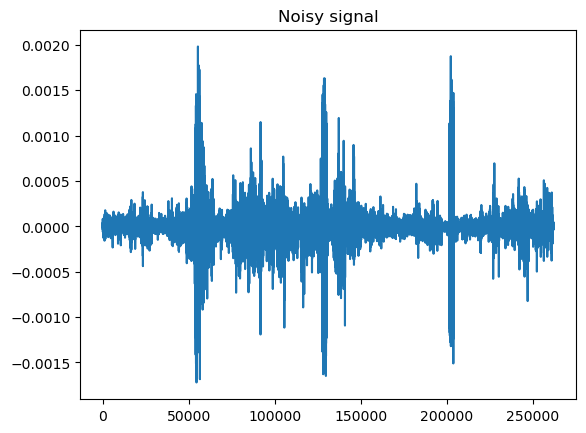

In [152]:
plt.plot(X)
plt.title('Noisy signal')
plt.show()

In [153]:
X.shape

(262143,)

## **🔹 Step 2: Compute the Wavelet Decomposition of the Noisy Signal**

**📌 Goal:** Apply a discrete wavelet transform (using the `wavelet_analysis` function) to the noisy signal increments generated in Step 1.

**📌 Why?** Wavelet decomposition converts the noisy time series into a multi-scale representation. This representation (stored in a `WaveletDec` object) is essential for extracting wavelet p-leaders, which are then used for outlier detection in multifractal analysis.

**📌 Key Output:** A `WaveletDec` object containing the wavelet coefficients across different scales, with border effects properly marked as `NaN`.



In [154]:
# Compute the wavelet decomposition using the 'db3' wavelet.
WT = wavelet_analysis(X, wt_name='db3', j2=None, normalization=1).integrate(gamint=1)

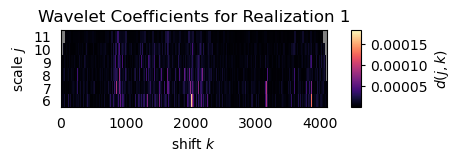

In [155]:
X_reshape = X.reshape(-1, 1)

for i in range(nb_generated_series):
    WT_realization = wavelet_analysis(X_reshape[:, i], wt_name='db3')  # i-th time series
    WT_realization.plot(j1=6, j2=11)
    plt.title(f"Wavelet Coefficients for Realization {i+1}")
    plt.show()



✔️ Interpretation:

* The plot displays the wavelet coefficients across scales.
* Regions affected by border effects are marked as NaN, ensuring they won’t interfere with further processing.


## **🔹 Step 3: Apply the Outlier Detection Algorithm**

**📌 Goal:** Use the `get_outliers` function to detect and flag outlier segments in the wavelet coefficients obtained in Step 2.

**📌 Why?** Impulsive noise can significantly bias multifractal estimates. By applying outlier detection, we segment the data using a PELT algorithm and compare segments via the Wasserstein distance, thereby flagging anomalous segments that likely correspond to noise impulses.

**📌 Key Output:** A tuple containing:  
- **leaders:** A `WaveletLeader` object with refined 1-leader coefficients.  
- **idx_reject:** A dictionary mapping each scale to a boolean mask that flags which coefficients are considered outliers.

**📌 Parameter Tuning:** The key parameters to adjust are:
  
- penalty: Controls segmentation sensitivity; higher values result in fewer segments
    - Lower values (5-15): More sensitive detection, good for clean signals with isolated artifacts
    - Higher values (20-50): Less sensitive, better for noisier signals

- threshold: Controls outlier classification threshold
    - Lower values (1.0-2.0): More aggressive outlier detection
    - Higher values (2.5-4.0): More conservative outlier detection




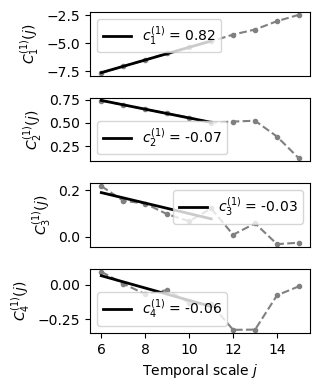

<Figure size 640x480 with 0 Axes>

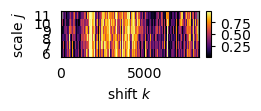

w=array([1., 1., 1., 1., 1., 1.])


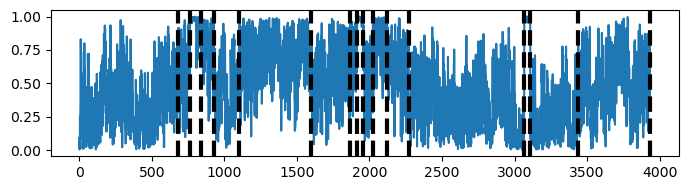

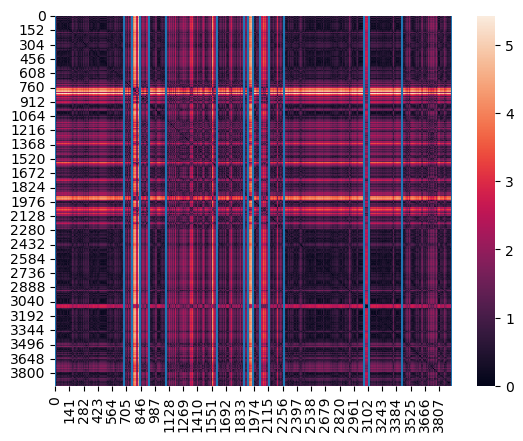

[np.float64(0.6191447988545183), np.float64(0.3807580343068823), np.float64(3.083905586138624), np.float64(0.7779885632955672), np.float64(0.3750277417595021), np.float64(0.7349902926859145), np.float64(0.28732902310977454), np.float64(0.9083388953544974), np.float64(3.8274713261463402), np.float64(0.31468213313061477), np.float64(1.4927220062432516), np.float64(0.3523462022586195), np.float64(0.6797842489937471), np.float64(3.898637054455256), np.float64(0.774258218817184), np.float64(0.2728400920695822)]
[np.float64(0.6161175723268233), np.float64(0.43511406558510574), np.float64(3.0616640167564526), np.float64(0.7300997877555357), np.float64(0.3723996677880072), np.float64(0.7684569877461631), np.float64(0.3383575414124106), np.float64(0.8619074506617616), np.float64(3.5619292040289383), np.float64(0.29535631854467215), np.float64(1.540722851320256), np.float64(0.3621499759630743), np.float64(0.6540635693467487), np.float64(3.260985146287533), np.float64(0.742279629651782), np.float

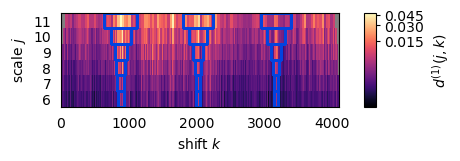

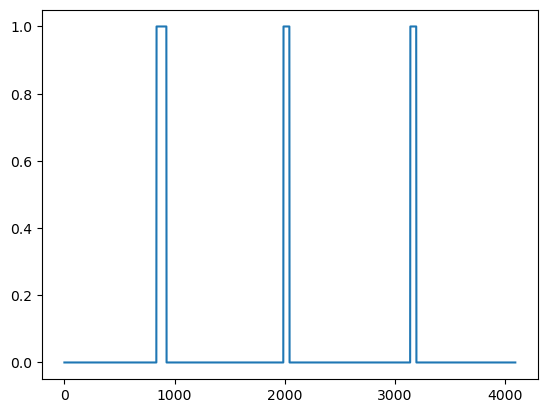

In [156]:
# Define parameters for outlier detection
scaling_ranges = [(6, 11)]   # Use scales 6 to 11 for linear regression in MFA
pelt_beta = 50               # Regularization parameter for the PELT segmentation
threshold = 3                # Wasserstein distance threshold for flagging outliers
pelt_jump = 1                # Check segmentation at every point
generalized = True           # Use the normal distribution model (results in 2 cumulants)
verbose = True               # Enable verbose output for debugging/tuning
remove_edges = False         # Do not remove edge coefficients automatically

# Run the outlier detection algorithm on the wavelet coefficients (wt_coefs from Step 2)
leaders, idx_reject = get_outliers(
    WT,
    scaling_ranges,
    pelt_beta,
    threshold,
    pelt_jump=pelt_jump,
    robust_cm=robust_cm,
    verbose=verbose,
    generalized=generalized,
    remove_edges=remove_edges
)

✔️ **Interpretation:**  


1. Cumulant Scaling Function (Fifth Plot)

- This plot shows the first four cumulants (C1, C2, C3, C4).
- The x-axis represents scale (j), while the y-axis represents cumulant values.
- The black solid lines show the regression fit, used to estimate multifractal properties.
- This is generated by mfa(), which estimates scaling functions from wavelet leaders.

2. Heatmap of Wavelet Leaders

- The color intensity represents wavelet leader values.
- This visualization is generated by compute_leaders().


3. Segmentation and Outlier Detection 

- This plot shows the segmented signal after applying the outlier detection algorithm.
- The dashed black lines mark the segments that have been flagged as containing outliers.
- This corresponds to the segmentation step in get_outliers(), which detects and removes abnormal segments.

4. Heatmap of Wavelet Coefficients 

- This is a wavelet decomposition representation at different scales.
- It is computed from wavelet_analysis().
- The x-axis represents time shifts (k), while the y-axis represents scale (j).
- The blue rectangles indicate detected outliers in the wavelet domain.(In blue: The coefficients flagged as outliers at each scale.)


6. Binary Mask Plot 

- This plot shows the binary mask used for noise injection.
- It corresponds to the create_mask3() function, which creates a mask of impulsive noise at specific locations.
- Each spike represents a time point where an impulsive noise segment has been added.




In [157]:
# Print a summary: number of coefficients flagged as outliers at each scale.
print("Detected outlier indices per scale:")
for scale, mask in idx_reject.items():
    num_outliers = mask.sum()  # count True values in the mask
    print(f"Scale {scale}: {num_outliers} coefficients flagged as outliers")

Detected outlier indices per scale:
Scale 6: 201 coefficients flagged as outliers
Scale 7: 120 coefficients flagged as outliers
Scale 8: 81 coefficients flagged as outliers
Scale 9: 59 coefficients flagged as outliers
Scale 10: 50 coefficients flagged as outliers
Scale 11: 43 coefficients flagged as outliers


--- 
## **🔹 Step 4: Run MFA after removing outliers**


In [158]:
# Run multifractal analysis using the wavelet leaders and the outlier rejection mask.
# Since generalized=False, only 2 cumulants are computed.
lwt = mfa(leaders, scaling_ranges=scaling_ranges, n_cumul=2, idx_reject=idx_reject)

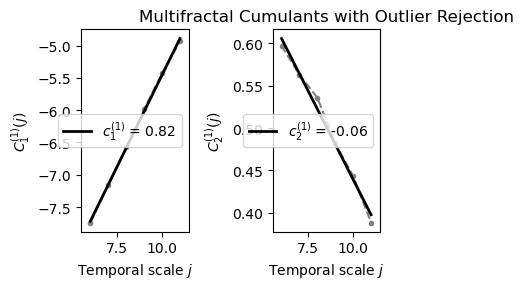

In [159]:
# Plot the computed cumulants.
# Ensure that the number of cumulants plotted (n_cumul) does not exceed the computed value.
lwt.cumulants.plot(j1=6,j2=11, n_cumul=2, nrow=1, figsize=(4, 3))
plt.title('Multifractal Cumulants with Outlier Rejection')
plt.show()


✔️ Interpretation:

* If verbose is enabled, additional figures may appear showing the segmentation process.
- \( c_1 \) represents the dominant scaling behavior of the signal.
- A **positive** \( c_1 \) suggests that the signal exhibits a **long-range dependence** and self-similarity.
- The higher the \( c_1 \), the **smoother** the process.
- The obtained value \( c_1 = 0.84 \) suggests a **moderate level of correlation** in the process across different scales.

- \( c_2 \) measures the **multifractality strength**, indicating how much the singularity spectrum broadens across scales.
- A **negative** \( c_2 \) confirms the presence of **multifractality**.
- However, the magnitude of \( |c_2| \) is **small**, meaning the multifractality is **weak**.
- If \( c_2 \) were more negative (e.g., \( -0.2 \) or lower), the signal would have **stronger multifractality**.


# **📊 Multifractal Analysis: Comparing Methods Under Different SNR Levels**

This analysis compares different estimation methods for multifractal properties under varying **Signal-to-Noise Ratio (SNR)** conditions. The goal is to determine which method is most **robust to noise**.

### **Methods Compared**
- **Naive estimation**: Standard approach without robustness adjustments.
- **Robust cumulants estimation**: Uses robust statistics to improve accuracy.
- **Log-exp power estimation**: Uses a generalized multifractal model with outlier rejection.

We analyze **c1 (Hölder exponent, smoothness)** and **c2 (Multifractality strength, deviation from monofractality)** across SNR levels.



In [160]:
# Define SNR and coverage grid
SNRgrid = np.r_[0, np.geomspace(.125, 8, 7)]
covgrid = np.array([3])
N = 2 ** 18

In [161]:
# Generate naive estimates
df_naive = gen_estimate(
    N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
    n_jobs=8, align_scale=12, lambd=np.sqrt(.05)
)

# Generate robust cumulants estimates
df_cm = gen_estimate(
    N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
    n_jobs=8, align_scale=12, robust_cm=True,
    lambd=np.sqrt(.05)
)

# Generate log-exp power method estimates (with outlier rejection)
# df_leader_gen = gen_estimate(
#     N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40, n_jobs=8,
#     align_scale=12, outlier_detect=True, lambd=np.sqrt(.05), robust_cm=False,
#     generalized=True,
#     robust_kwargs=dict(pelt_jump=5, pelt_beta=50, threshold=3)
# )




In [163]:
# Combine the results into a single DataFrame for comparison
df_plot2 = pd.concat([
    df_naive.stack().loc[:, :, 3],
    df_cm.stack().loc[:, :, 3],
    #df_leader_gen.stack().loc[:, :, 3],
], keys=['Naive', 'Robust cumulants'], names=['method', 'rep', 'SNR'])

/var/folders/_p/stbgbx154_v2mk71nn05yw5r0000gn/T/ipykernel_27471/3761727040.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_naive.stack().loc[:, :, 3],
/var/folders/_p/stbgbx154_v2mk71nn05yw5r0000gn/T/ipykernel_27471/3761727040.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cm.stack().loc[:, :, 3],


In [174]:
df_plot2.groupby(['method','SNR']).mean()


cumulant                      c1        c2
method           SNR                      
Naive            0.000  0.833126 -0.051221
                 0.125  0.826512 -0.063954
                 0.250  0.828971 -0.078168
                 0.500  0.836408 -0.088629
                 1.000  0.848671 -0.087761
                 2.000  0.865701 -0.069726
                 4.000  0.887482 -0.030014
                 8.000  0.913512  0.034679
Robust cumulants 0.000  0.831120 -0.047749
                 0.125  0.826448 -0.062771
                 0.250  0.835847 -0.060863
                 0.500  0.850153 -0.046506
                 1.000  0.859356 -0.031295
                 2.000  0.860393 -0.015347
                 4.000  0.859221  0.000167
                 8.000  0.858345  0.016265

✔️ Interpretation:

* Naive estimation shows increasing c₁ and c₂ with higher SNR, suggesting that noise inflates the perceived multifractality.
* Robust cumulants offer better stabilization to c₁ and c₂, preventing artificial multifractality but still showing some sensitivity to noise.
* Outlier rejection allow us to distinguish true multifractality from noise artifacts, leading to more reliable results. 

In [ ]:
benchmark = Benchmark(
    signal_param_grid=signal_param_grid,
    signal_func=generate_simuls_bb,
    estimation_grid={
        "mfa": lambda WT: estimate(
            WT, robust_cm=False, bootstrap_weight=False, outlier_detect=True,
            generalized=True, robust_kwargs=dict(pelt_jump=5, pelt_beta=50, threshold=3)
        )
    },
    WT_params={"wt_name": "db6"},
    folder=Path("./benchmark_results")
)
benchmark.compute_benchmark(n_jobs=8, save=True)
